<a href="https://colab.research.google.com/github/zakariyyabrewster/pytorch-unet/blob/main/unet_pipeline_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/zakariyyabrewster/pytorch-unet

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 990, done.
remote: Counting objects: 100% (990/990), done.
remote: Compressing objects: 100% (571/571), done.
remote: Total 990 (delta 446), reused 908 (delta 407), pack-reused 0 (from 0)
Receiving objects: 100% (990/990), 22.30 MiB | 40.06 MiB/s, done.
Resolving deltas: 100% (446/446), done.


In [ ]:
%cd content/pytorch-unet

/content/pytorch-unet


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.3.0
    Uninstalling pillow-11.3.0:
      Successfully uninstalled pillow-11.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled 

In [ ]:
!python train.py --epochs 20 -l 5e-5 --amp

INFO: Using device cuda
INFO: Network:
	1 input channels
	1 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 412 examples
INFO: Scanning mask files to determine unique values
100% 412/412 [00:00<00:00, 1706.88it/s]
INFO: Unique mask values: [0, 255]
wandb: Currently logged in as: anony-mouse-527941313062370929 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in /content/pytorch-unet/wandb/run-20250718_192908-1vzpvk8e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cerulean-deluge-2
wandb: ⭐️ View project at https://wandb.ai/anony-mouse-527941313062370929/U-Net?apiKey=af307e285a62ec817c1d86056c0961174bc90504
wandb: 🚀 View run at https://wandb.ai/anony-mouse-527941313062370929/U-Net/runs/1vzpvk8e?apiKey=af307e285a62ec817c1d86056c0961174bc90504
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.
INFO: S

In [ ]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet import UNet
from utils.utils import plot_img_and_mask
import matplotlib.pyplot as plt

def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    dummy = mask[0].cpu().squeeze().numpy()
    return dummy.astype(np.uint8)

def load_mask(path):
    return np.array(Image.open(path)) // 255

class InstanceMetrics:
    def __init__(self, gt, pred):
        self.gt = gt.astype(bool)
        self.pred = pred.astype(bool)
        self.tp = np.sum(self.gt & self.pred)
        self.tn = np.sum(~self.gt & ~self.pred)
        self.fp = np.sum(~self.gt & self.pred)
        self.fn = np.sum(self.gt & ~self.pred)
        self.union = np.sum(self.gt) + np.sum(self.pred) - self.tp
        self.beta = 0.3
        self.precision = self.tp / (self.tp + self.fp + 1e-8)
        self.recall = self.tp / (self.tp + self.fn + 1e-8)
        self.f_measure = ((1 + self.beta ** 2) * self.precision * self.recall) / (self.beta ** 2 * self.precision + self.recall + 1e-8)
        self.tpr = self.recall
        self.fpr = self.fp / (self.fp + self.tn + 1e-8)
        self.iou = self.tp / (self.union + 1e-8)

    def __str__(self):
        return f"Precision: {self.precision:.4f}, Recall: {self.recall:.4f}, F-measure: {self.f_measure:.4f} \nTrue Positive Rate (TPR): {self.tpr:.4f}, False Positive Rate (FPR): {self.fpr:.4f}, IoU: {self.iou:.4f}"

class EvalMetrics:
    def __init__(self, metrics_list):
        self.metrics_list = metrics_list
        self.mIoU = np.mean([metric.iou for metric in metrics_list])
        self.mFmeasure = np.mean([metric.f_measure for metric in metrics_list])
        self._computePR()
        self._computeROC()
        os.makedirs('metrics', exist_ok=True)

    def _computePR(self):
        self.precision_list = []
        self.recall_list = []
        for metric in self.metrics_list:
            self.precision_list.append(metric.precision)
            self.recall_list.append(metric.recall)

        recall_array = np.array(self.recall_list)
        precision_array = np.array(self.precision_list)
        sort_idx = np.argsort(recall_array)
        recall_array = recall_array[sort_idx]
        precision_array = precision_array[sort_idx]

        # Compute area under the curve using trapezoidal integration
        self.AP = np.trapz(precision_array, recall_array)

        mean_precision = np.mean(self.precision_list)
        mean_recall = np.mean(self.recall_list)
        self.meanPR = (mean_recall, mean_precision)
        print(f"Mean Precision: {mean_precision:.4f}, Mean Recall: {mean_recall:.4f}, AP: {self.AP:.4f}")

    def plot_curves(self):
        fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12, 6))

        # — ROC subplot —
        ax_roc.scatter(self.fpr_list, self.tpr_list, marker='.', label='ROC curve')
        ax_roc.scatter(
            self.meanROC[0], self.meanROC[1],
            marker='o', color='red', s=100,
            label=f'Mean ROC: TPR={self.meanROC[1]:.4f}, FPR={self.meanROC[0]:.4f}'
        )
        ax_roc.axhline(
            y=self.AUC, color='blue', linestyle='--',
            label=f'AUC = {self.AUC:.4f}'
        )
        ax_roc.set_xlabel('False Positive Rate')
        ax_roc.set_ylabel('True Positive Rate')
        ax_roc.set_title('ROC Curve')
        ax_roc.legend()
        ax_roc.grid(True)

        # — Precision–Recall subplot —
        ax_pr.scatter(self.recall_list, self.precision_list, marker='.', label='PR curve')
        ax_pr.scatter(
            self.meanPR[1], self.meanPR[0],
            marker='o', color='red', s=100,
            label=f'Mean PR: P={self.meanPR[0]:.4f}, R={self.meanPR[1]:.4f}'
        )
        ax_pr.axhline(
            y=self.AP, color='blue', linestyle='--',
            label=f'AP = {self.AP:.4f}'
        )
        ax_pr.set_xlabel('Recall')
        ax_pr.set_ylabel('Precision')
        ax_pr.set_title('Precision–Recall Curve')
        ax_pr.legend()
        ax_pr.grid(True)

        plt.tight_layout()
        fig.savefig('metrics/combined_ROC_PR.png')
        plt.show()


    def _computeROC(self):
        self.fpr_list = []
        self.tpr_list = []
        for metric in self.metrics_list:
            self.fpr_list.append(metric.fpr)
            self.tpr_list.append(metric.tpr)

        fpr_array = np.array(self.fpr_list)
        tpr_array = np.array(self.tpr_list)
        sort_idx = np.argsort(fpr_array)
        fpr_array = fpr_array[sort_idx]
        tpr_array = tpr_array[sort_idx]

        # Compute area under the curve using trapezoidal integration
        self.AUC = np.trapz(tpr_array, fpr_array)

        mean_fpr = np.mean(self.fpr_list)
        mean_tpr = np.mean(self.tpr_list)
        self.meanROC = (mean_fpr, mean_tpr)
        print(f"Mean FPR: {mean_fpr:.4f}, Mean TPR: {mean_tpr:.4f}, AUC: {self.AUC:.4f}")

    def display_metrics(self):
        print(f"Mean IoU: {self.mIoU:.4f}")
        print(f"Mean F-measure: {self.mFmeasure:.4f}")
        self.plotPR()
        self.plotROC()

Threshold: 0.00
Mean Precision: 0.0006, Mean Recall: 1.0000, AP: 0.0000
Mean FPR: 1.0000, Mean TPR: 1.0000, AUC: 0.0000


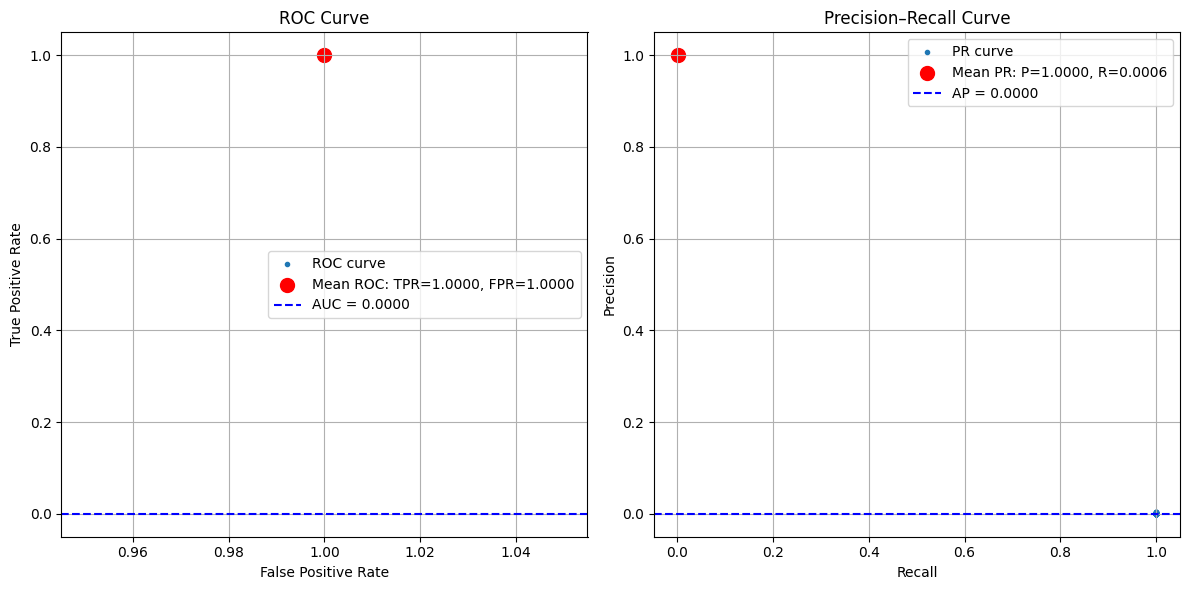

Threshold: 0.05
Mean Precision: 0.4596, Mean Recall: 0.8299, AP: 0.7749
Mean FPR: 0.0025, Mean TPR: 0.8299, AUC: 0.2254


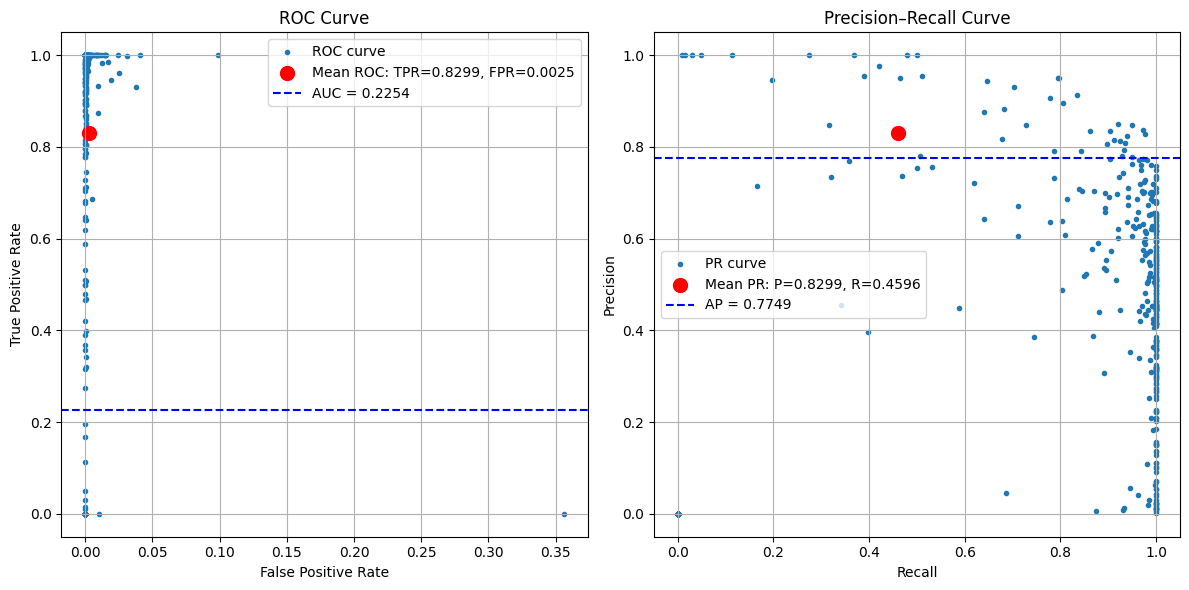

Threshold: 0.10
Mean Precision: 0.5285, Mean Recall: 0.7803, AP: 0.7619
Mean FPR: 0.0019, Mean TPR: 0.7803, AUC: 0.1804


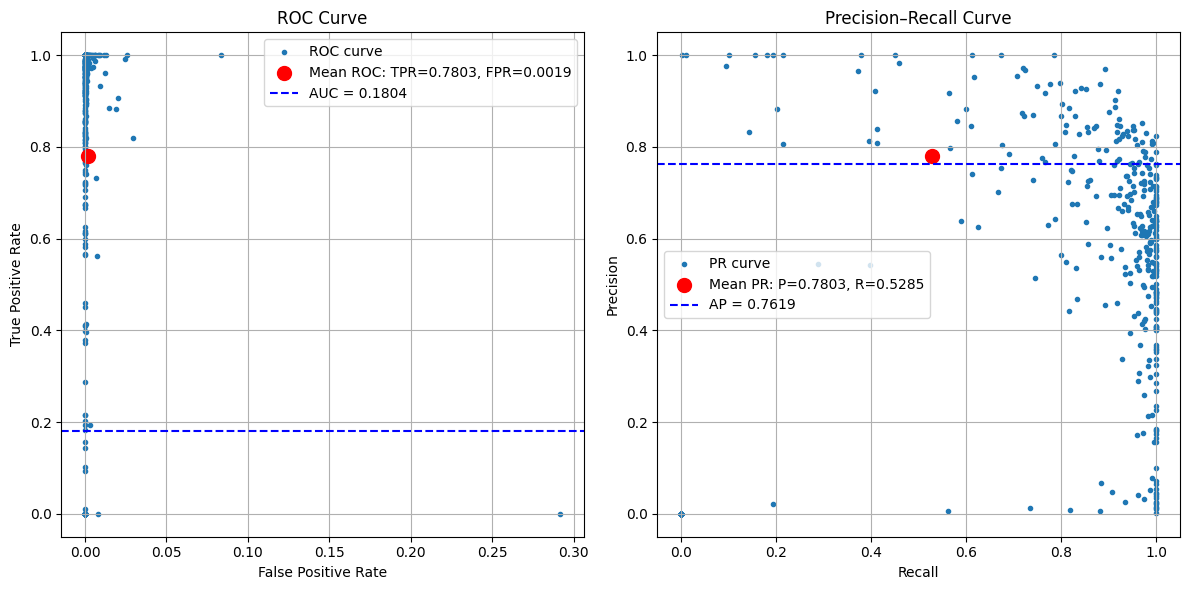

Threshold: 0.15
Mean Precision: 0.5718, Mean Recall: 0.7394, AP: 0.8263
Mean FPR: 0.0015, Mean TPR: 0.7394, AUC: 0.1538


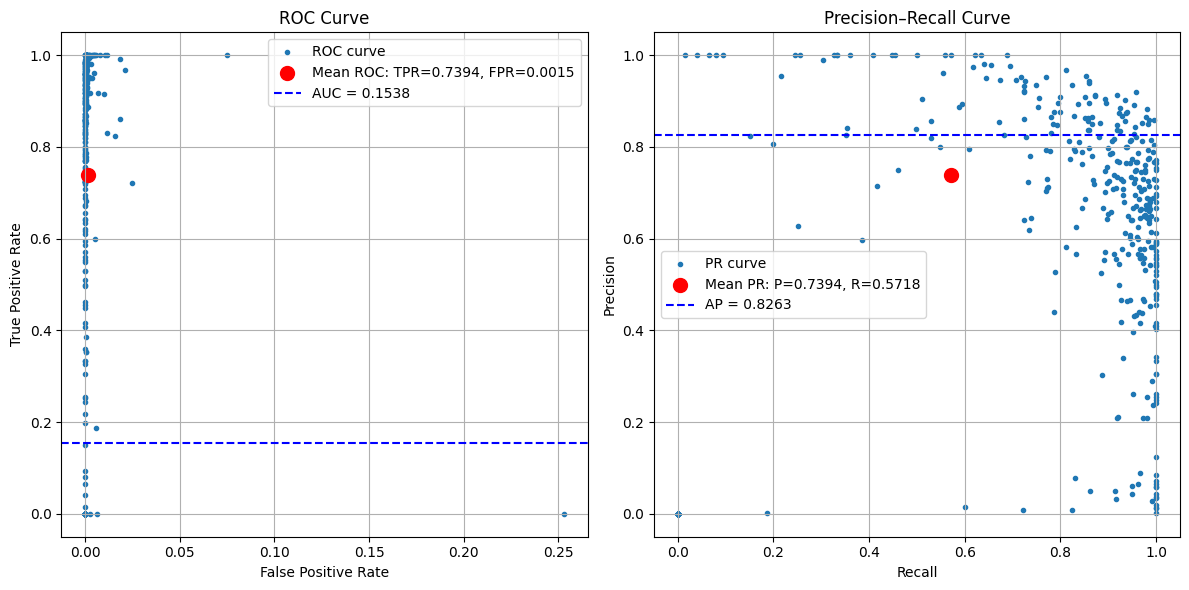

Threshold: 0.20
Mean Precision: 0.6072, Mean Recall: 0.6983, AP: 0.8550
Mean FPR: 0.0013, Mean TPR: 0.6983, AUC: 0.1347


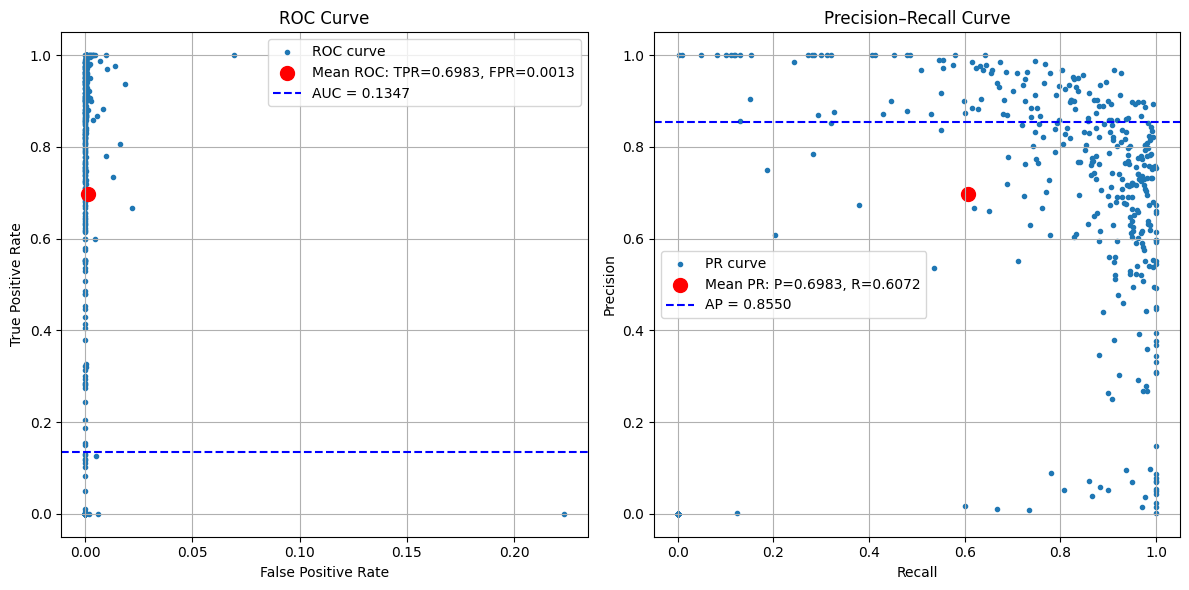

Threshold: 0.25
Mean Precision: 0.6218, Mean Recall: 0.6585, AP: 0.8629
Mean FPR: 0.0011, Mean TPR: 0.6585, AUC: 0.1181


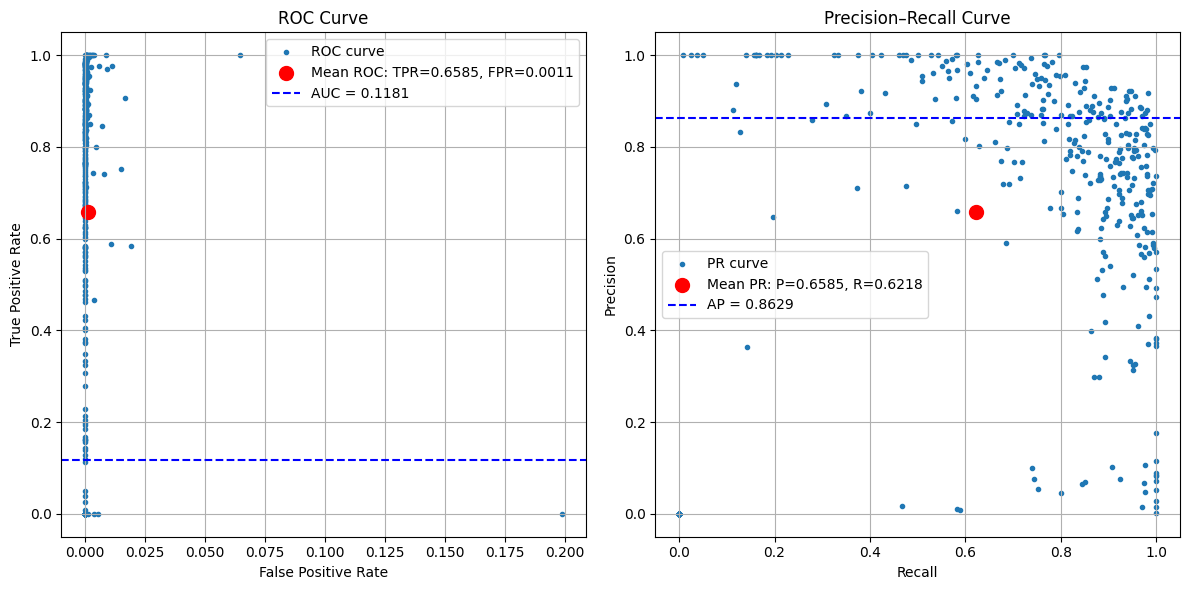

Threshold: 0.30
Mean Precision: 0.6298, Mean Recall: 0.6223, AP: 0.8769
Mean FPR: 0.0010, Mean TPR: 0.6223, AUC: 0.0992


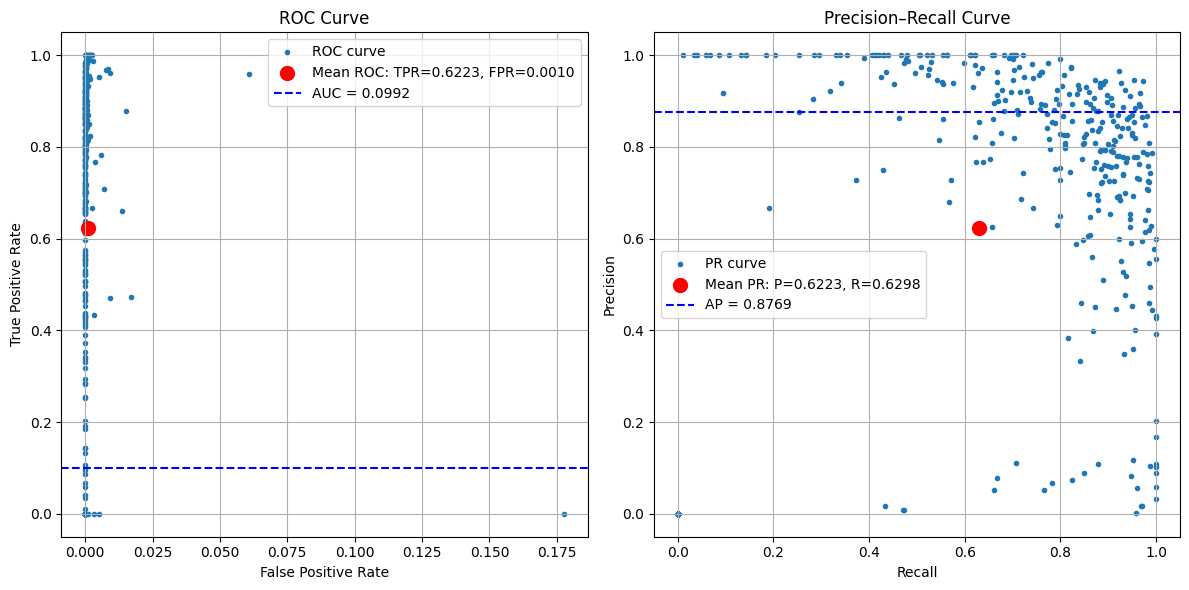

Threshold: 0.35
Mean Precision: 0.6359, Mean Recall: 0.5868, AP: 0.8647
Mean FPR: 0.0009, Mean TPR: 0.5868, AUC: 0.0851


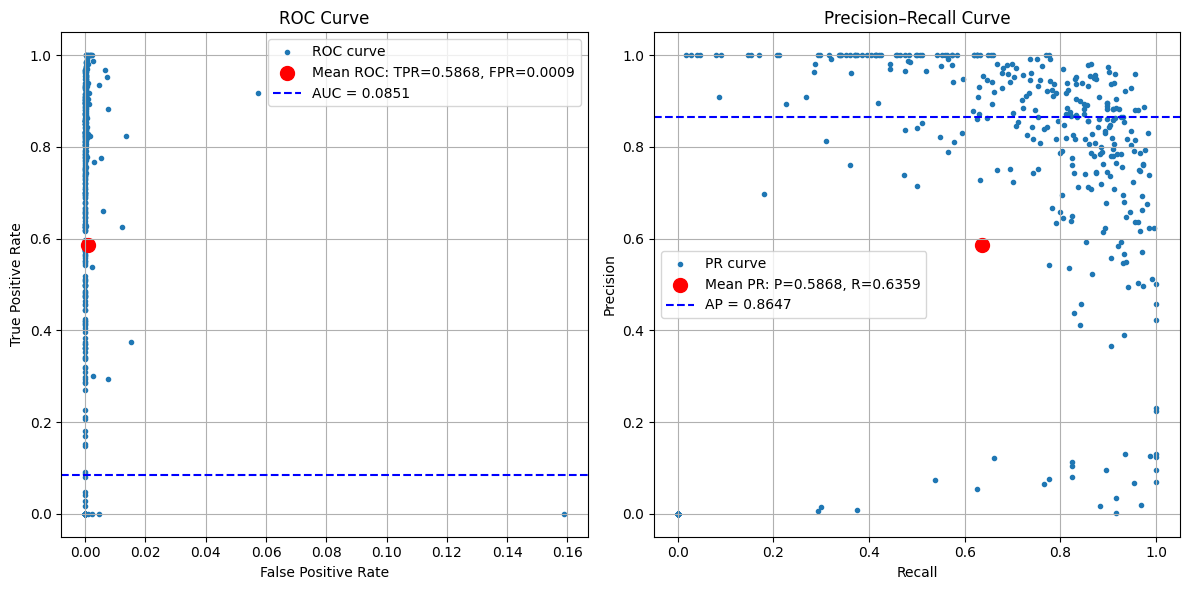

Threshold: 0.40
Mean Precision: 0.6473, Mean Recall: 0.5509, AP: 0.8511
Mean FPR: 0.0008, Mean TPR: 0.5509, AUC: 0.0750


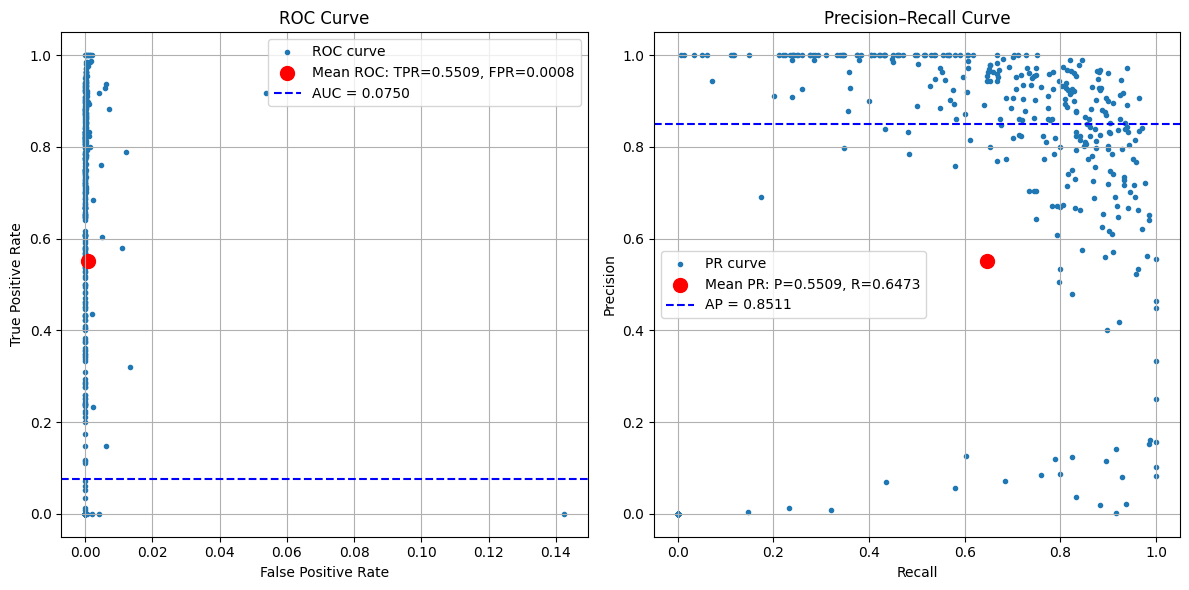

Threshold: 0.45
Mean Precision: 0.6526, Mean Recall: 0.5160, AP: 0.8691
Mean FPR: 0.0007, Mean TPR: 0.5160, AUC: 0.0661


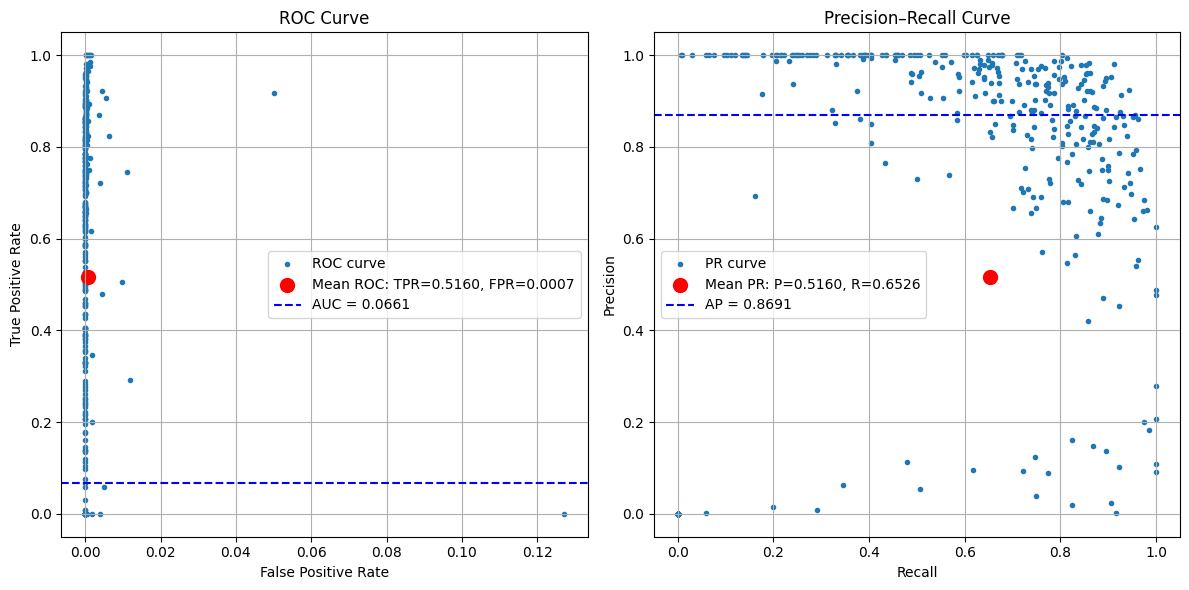

Threshold: 0.50
Mean Precision: 0.6569, Mean Recall: 0.4799, AP: 0.8707
Mean FPR: 0.0006, Mean TPR: 0.4799, AUC: 0.0522


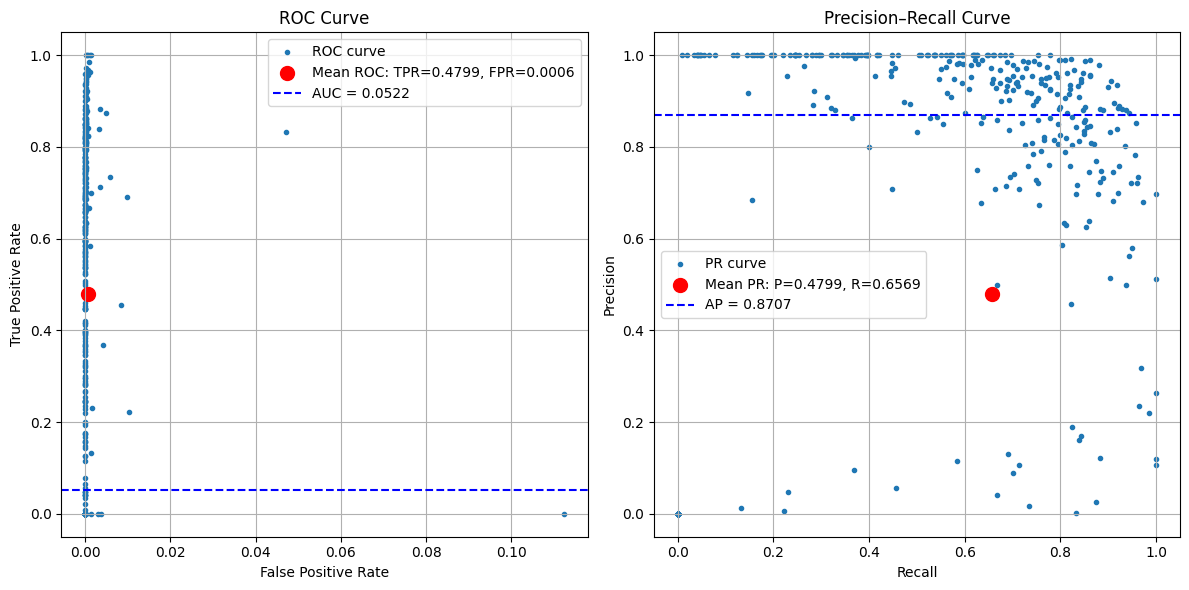

Threshold: 0.55
Mean Precision: 0.6406, Mean Recall: 0.4424, AP: 0.8547
Mean FPR: 0.0005, Mean TPR: 0.4424, AUC: 0.0420


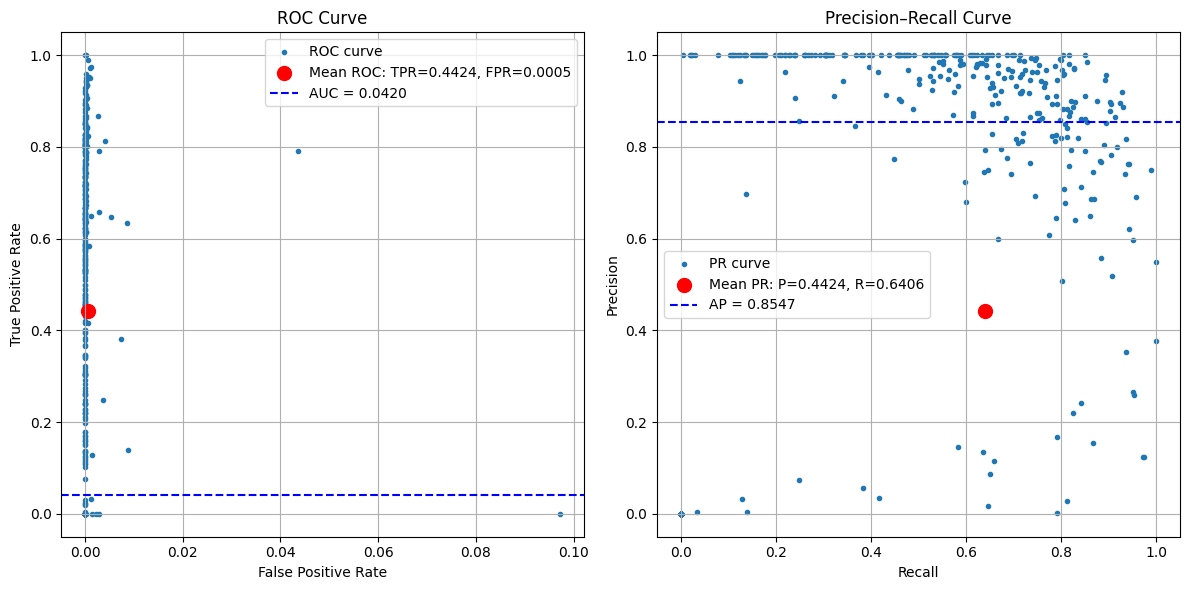

Threshold: 0.60
Mean Precision: 0.6339, Mean Recall: 0.4060, AP: 0.8784
Mean FPR: 0.0005, Mean TPR: 0.4060, AUC: 0.0352


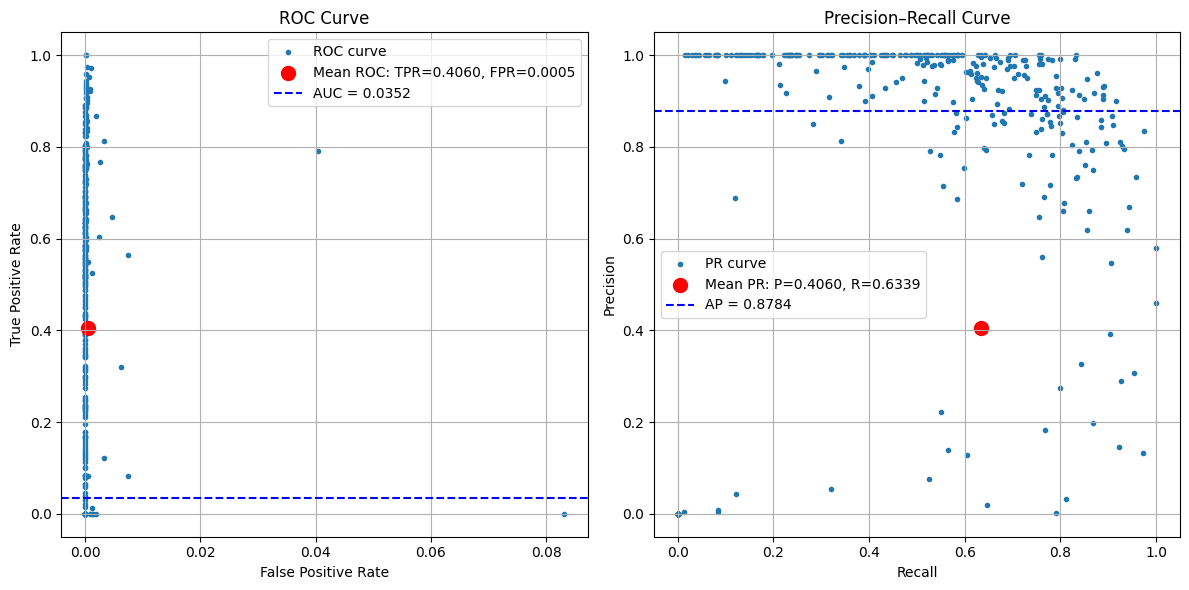

Threshold: 0.65
Mean Precision: 0.6222, Mean Recall: 0.3675, AP: 0.8946
Mean FPR: 0.0004, Mean TPR: 0.3675, AUC: 0.0242


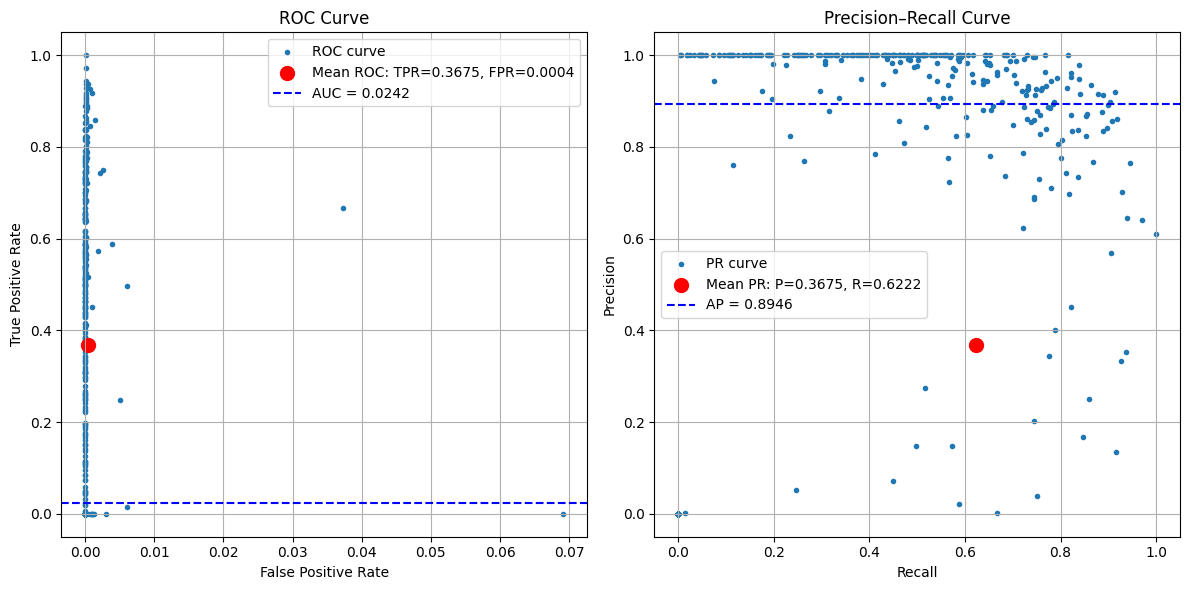

Threshold: 0.70
Mean Precision: 0.5934, Mean Recall: 0.3293, AP: 0.8848
Mean FPR: 0.0003, Mean TPR: 0.3293, AUC: 0.0227


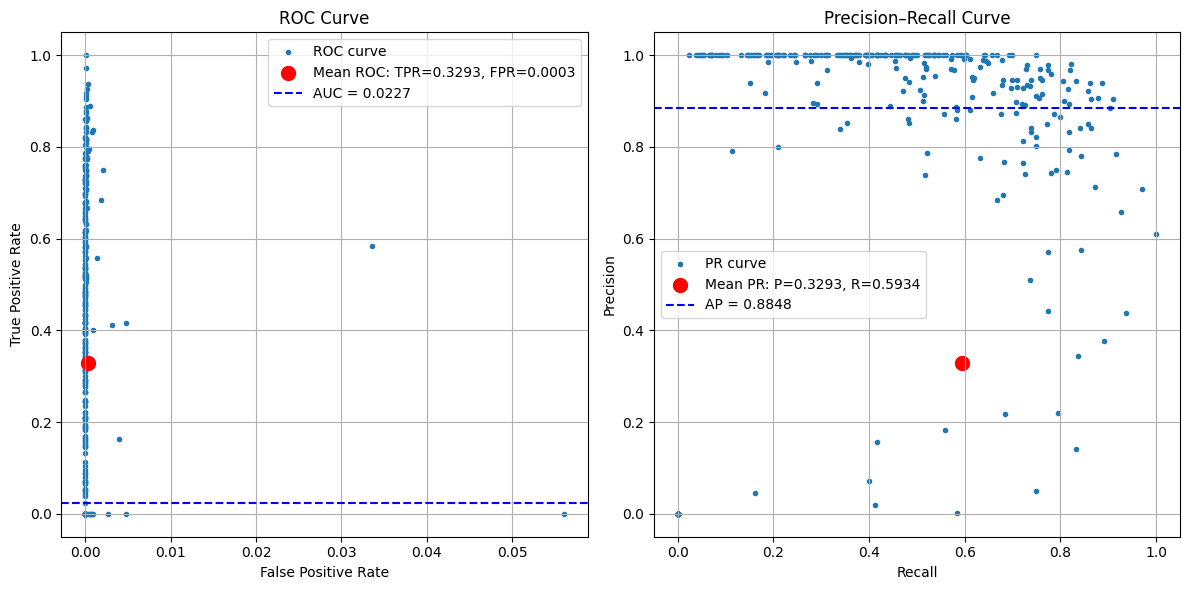

Threshold: 0.75
Mean Precision: 0.5788, Mean Recall: 0.2893, AP: 0.8665
Mean FPR: 0.0002, Mean TPR: 0.2893, AUC: 0.0111


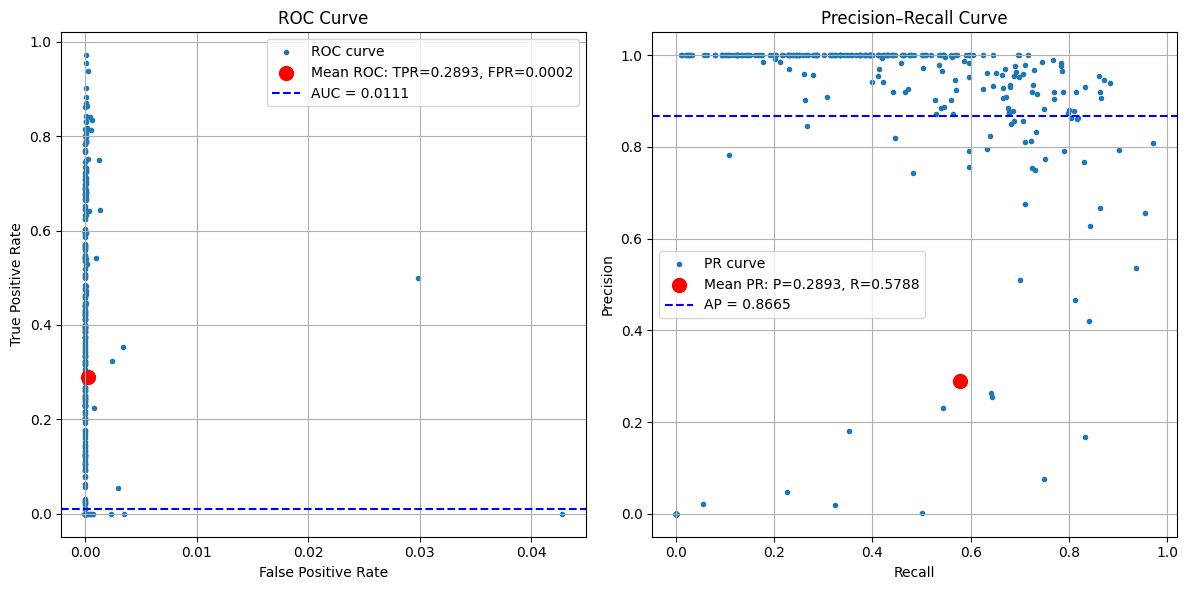

Threshold: 0.80
Mean Precision: 0.5509, Mean Recall: 0.2466, AP: 0.8422
Mean FPR: 0.0002, Mean TPR: 0.2466, AUC: 0.0076


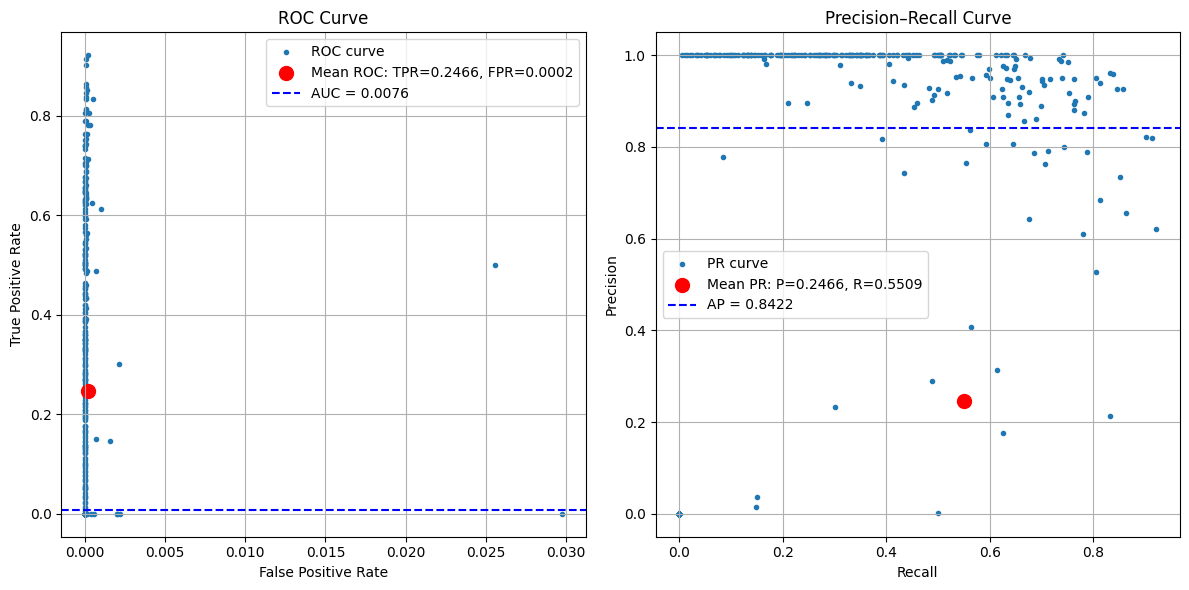

Threshold: 0.85
Mean Precision: 0.5016, Mean Recall: 0.2009, AP: 0.8494
Mean FPR: 0.0001, Mean TPR: 0.2009, AUC: 0.0007


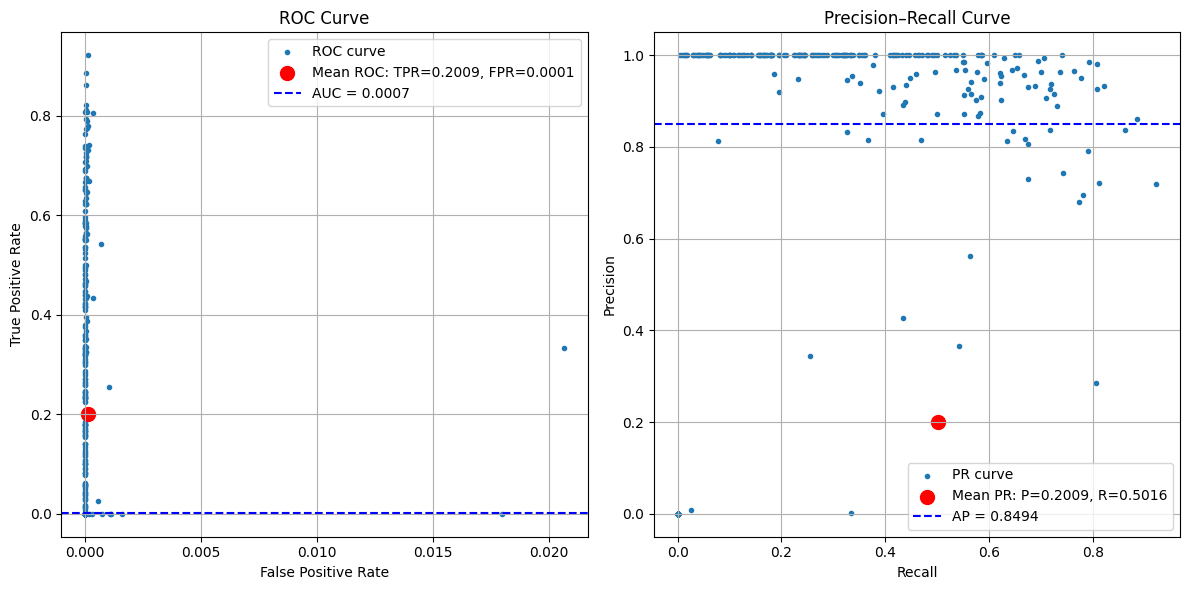

Threshold: 0.90
Mean Precision: 0.4307, Mean Recall: 0.1520, AP: 0.8121
Mean FPR: 0.0001, Mean TPR: 0.1520, AUC: 0.0008


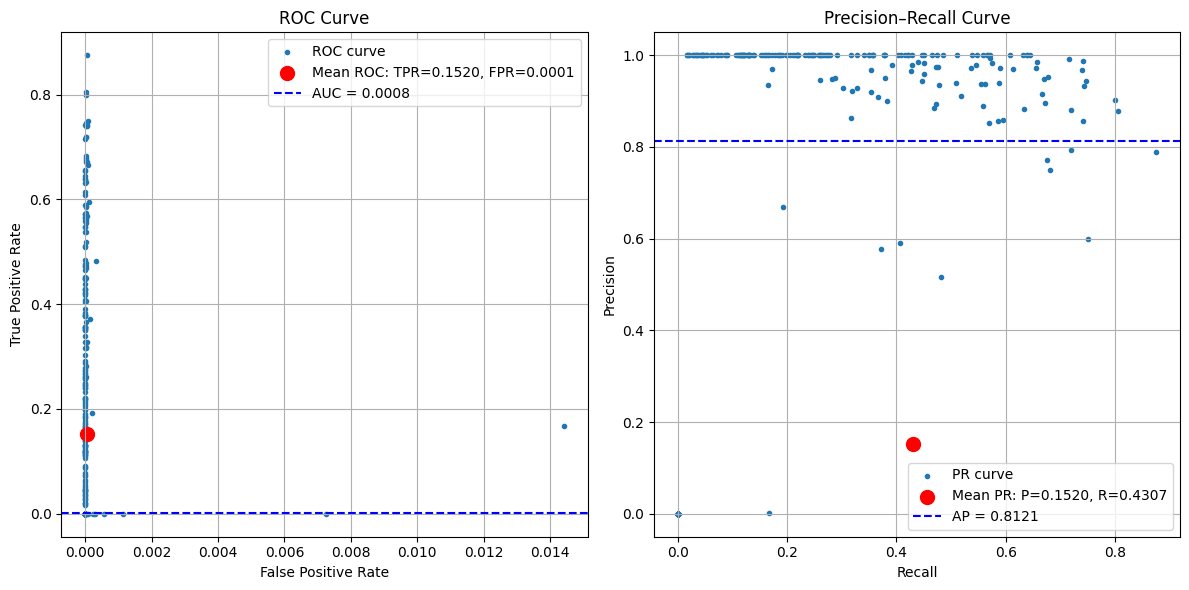

Threshold: 0.95
Mean Precision: 0.3268, Mean Recall: 0.0932, AP: 0.7969
Mean FPR: 0.0000, Mean TPR: 0.0932, AUC: 0.0000


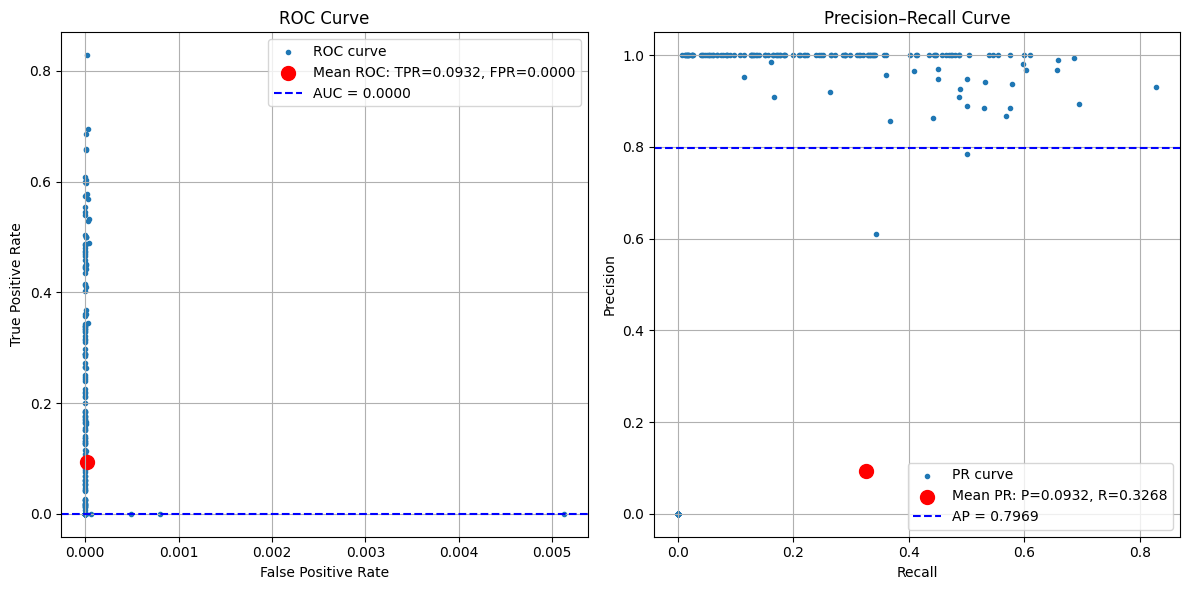

Threshold: 1.00
Mean Precision: 0.0000, Mean Recall: 0.0000, AP: 0.0000
Mean FPR: 0.0000, Mean TPR: 0.0000, AUC: 0.0000


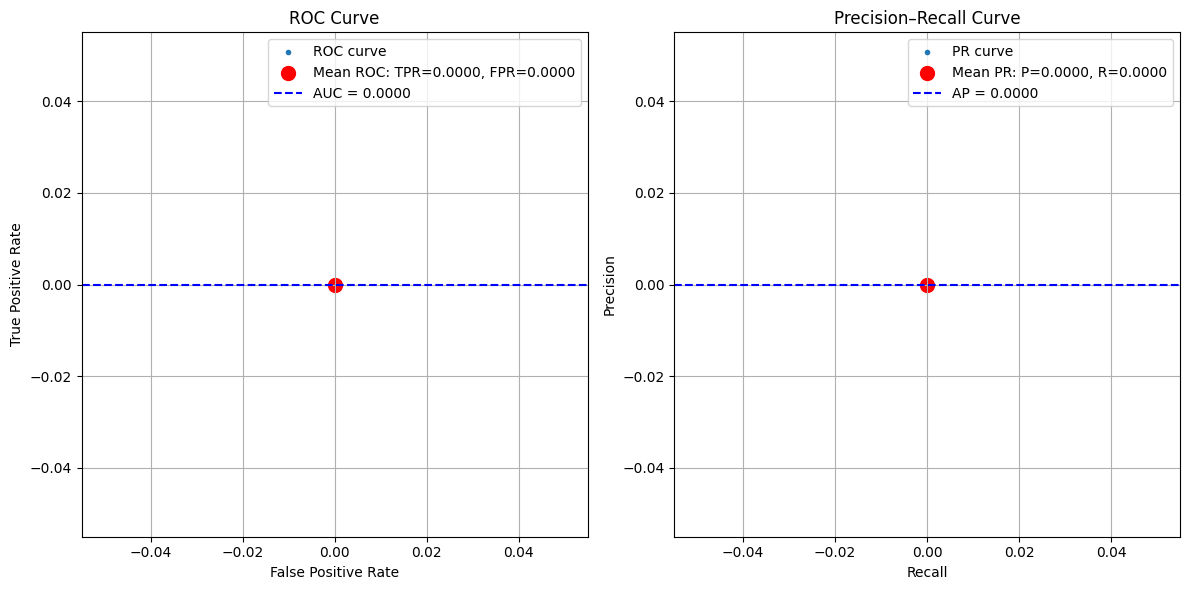

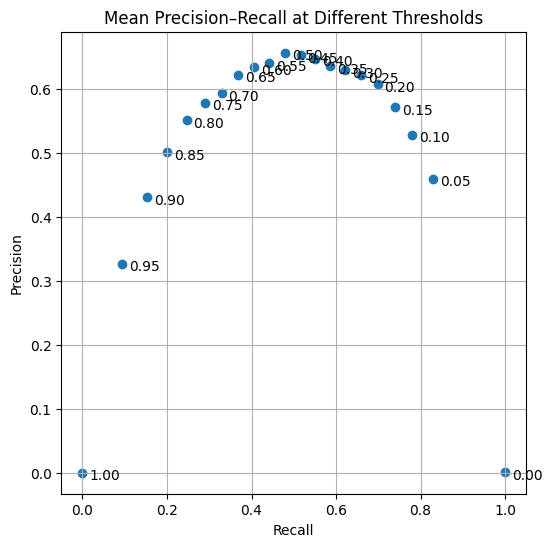

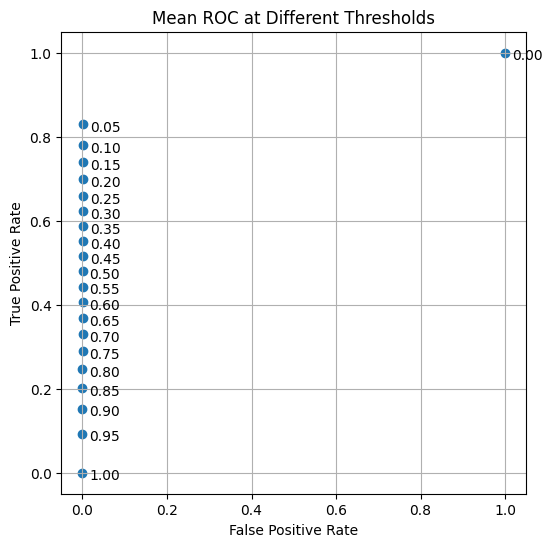

In [ ]:
import glob
# e.g. all .txt files in a directory
img_files = glob.glob('data/imgs/*.png')

model = 'checkpoints/checkpoint_final.pth'

net = UNet(n_channels=1, n_classes=1, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
state_dict = torch.load(model, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

logging.info('Model loaded!')

threshs = np.linspace(0, 1, 21)

thresholds = []
precisions = []
recalls = []
tprs = []
fprs = []

for t in threshs:
    all_metrics = []
    for i, filename in enumerate(img_files):
        logging.info(f'Predicting image {filename} ...')
        img = Image.open(filename)
        fn = os.path.basename(filename)
        name, _ = os.path.splitext(fn)
        gt_path = os.path.join("data", "masks", f"{name}_pixels0.png")
        gt = load_mask(gt_path)
        pred = predict_img(net=net,
                            full_img=img,
                            scale_factor=0.5,
                            out_threshold=t,
                            device=device)
        metrics_i = InstanceMetrics(gt, pred)
        all_metrics.append(metrics_i)
    print(f'Threshold: {t:.2f}')
    all_metrics_eval = EvalMetrics(all_metrics)
    all_metrics_eval.plot_curves()
    thresholds.append(t)
    recalls.append(all_metrics_eval.meanPR[0])
    precisions.append(all_metrics_eval.meanPR[1])
    fprs.append(all_metrics_eval.meanROC[0])
    tprs.append(all_metrics_eval.meanROC[1])

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(recalls, precisions, marker='o')
for x, y, t in zip(recalls, precisions, thresholds):
    ax.annotate(f'{t:.2f}', (x, y), textcoords="offset points", xytext=(5,-5))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Mean Precision–Recall at Different Thresholds')
ax.grid(True)
fig.savefig('PR_by_threshold.png')

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(fprs, tprs, marker='o')
for x, y, t in zip(fprs, tprs, thresholds):
    ax.annotate(f'{t:.2f}', (x, y), textcoords="offset points", xytext=(5,-5))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Mean ROC at Different Thresholds')
ax.grid(True)
fig.savefig('ROC_by_threshold.png')

plt.show()

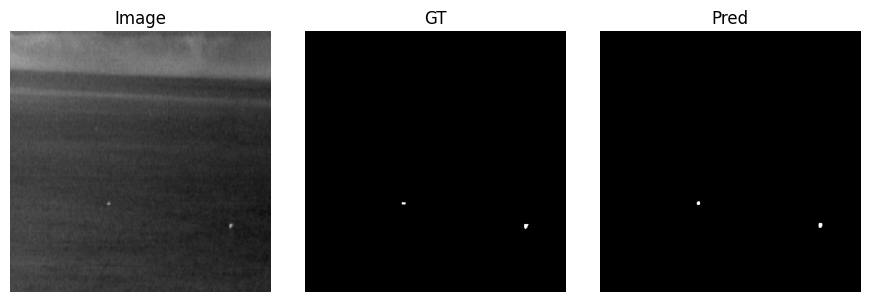

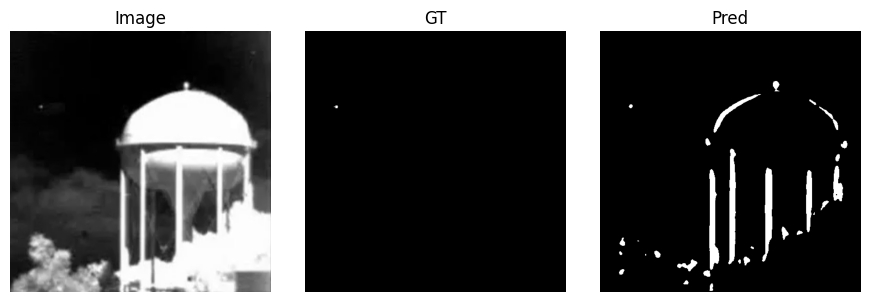

In [ ]:
test_img_files = ['data/imgs/Misc_105.png', 'data/imgs/Misc_121.png']
model = 'checkpoints/checkpoint_final.pth'
net = UNet(n_channels=1, n_classes=1, bilinear=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)
state_dict = torch.load(model, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

for i, filename in enumerate(test_img_files):
    img = Image.open(filename)
    fn = os.path.basename(filename)
    name, _ = os.path.splitext(fn)
    gt_path = os.path.join("data", "masks", f"{name}_pixels0.png")
    gt = load_mask(gt_path)
    pred = predict_img(net=net,
                        full_img=img,
                        scale_factor=0.5,
                        out_threshold=0.5,
                        device=device)
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    # Full grayscale image
    axes[0].imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Mask 1
    axes[1].imshow(gt, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('GT')
    axes[1].axis('off')

    # Mask 2
    axes[2].imshow(pred, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title('Pred')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()